## Set up environment paths

In [2]:
import setup

setup.main()
RAW_DIR, BINNED_DIR = setup.get_data_dir()

%load_ext autoreload
%autoreload 2

Working directory:  /Users/facosta/Desktop/code/neurometry/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry
The raw data is located in the directory:
/Users/facosta/Desktop/code/neurometry/neurometry/data/raw.
The binned data is located in the directory:
/Users/facosta/Desktop/code/neurometry/neurometry/data/binned.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import viz
import neurometry.datasets.utils as utils
import neurometry.datasets.experimental as experimental
import os
from lovely_numpy import lo
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from scipy import signal
from scipy.interpolate import interp1d

INFO: Using pytorch backend


## Inspect Raw Data

In [4]:
expt_id = "34"

expt = utils.loadmat(os.path.join(RAW_DIR, f"expt{expt_id}.mat"))

metadata = list(expt["x"].keys())
print(f"You can find metadata about:\n {metadata}.")

You can find metadata about:
 ['rat', 'day', 'epoch', 'type', 'finalGain', 'rosdata', 'clust', 'specGain'].


In [5]:
rat_id = expt["x"]["rat"]
print(f"The data was collected from rat {rat_id}.")

day = expt["x"]["day"]
print(f"The data was collected on day {day}.")

n_cells = len(expt["x"]["clust"])
print(f"There are {n_cells} neurons recorded in this experiment.")

epoch = expt["x"]["epoch"]
print(f"Epoch =  {epoch}")

final_gain = expt["x"]["finalGain"]
print(f"Final gain =  {final_gain}")

if np.unique(expt["x"]["rosdata"]["gain"]).size == 1:
    print("The gain is constant throughout the experiment")
else:
    print("The gain changes throughout the experiment")
    plt.plot(expt["x"]["rosdata"]["gain"])
    plt.title("Gain")

The data was collected from rat 637.
The data was collected on day 6.
There are 40 neurons recorded in this experiment.
Epoch =  m1
Final gain =  1
The gain is constant throughout the experiment


## Define experimental variables


- startTs: time in microseconds 

- stopTs: time in microseconds 

- encTimes: "encoder" times 

- encAngle: recorded angles of rat

- subepochs: "m1" exprrimental session, + periods where gain eitehr takes a different value or changes

- landAngle: angle of landmark frame

- gain: 

- vel: velocity of rat (degrees/s - close to cm/s here)

- relAngle: encAngle - landAngle

- landOffTime: when landmamarks turned off

- landOffAngle: encAngle(landOfftime) -- encAngle[landOffIdx]

- landOffIdx: index of lanfOffAngle

- estGain: gain estimated through Fourier analysis

- hippAngle: integral of G d$\theta$ angle of rat in estimated hippocampal frame

## Load neural activity + measured lab variables ("labels")

This section walks through the processing of the experimental data to obtain neural activity vectors and corresponding laboratory measurements. 
The result is identical to the ouput of `neurometry.datasets.experimental.load_neural_activity` used in the following section

**Set velocity threshold (in degrees/second)**

In [8]:
velocity_threshold = 10

**Find all contigious periods where velocity > threshold** : 
Each element of `period_start_times` and `period_end_times` is a time in `exp["x"]["rosdata"]["encTimes"]` where a contiguous period with velocity > threshold starts and ends, respectively

Mean rise length: 0.8364406146112601 seconds
Median rise length: 0.430033375 seconds
Total number of rise events: 746


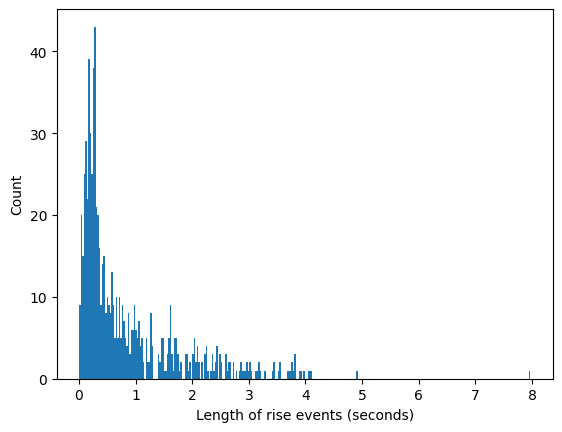

In [9]:
period_start_times, period_end_times, df = experimental._apply_velocity_threshold(
    expt, threshold=velocity_threshold
)

**Set binning timestep (in microseconds)**

In [170]:
timestep_microseconds = int(1e5)

**Find bin edges (`sampling_times`) for all valid bins (all bins in every period where velocity > threshold)**

In [171]:
sampling_times = experimental._get_sampling_times(
    period_start_times, period_end_times, timestep_microseconds
)

print(
    f"There are {len(sampling_times)} valid time periods of duration AT LEAST {timestep_microseconds} microseconds"
)

There are 891 valid time periods of duration AT LEAST 100000 microseconds


**Visualize thresholded sampling**

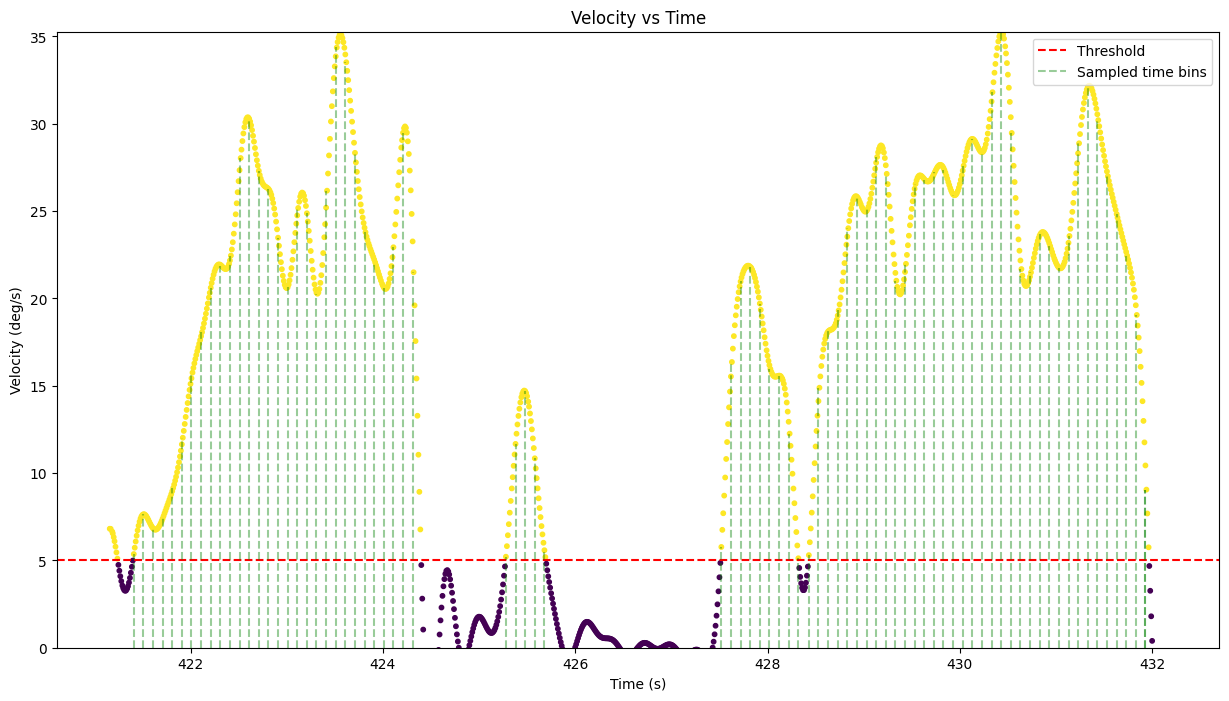

In [80]:
fig = plt.figure(figsize=(15, 8))

i_start = 6000
i_end = 7100

times_secs = df["encTimes"][i_start:i_end] * 1e-6
velocities = df["vel"][i_start:i_end]
colors = df["above_threshold"][i_start:i_end]


plt.scatter(times_secs, velocities, c=colors, cmap="viridis", s=10)
plt.axhline(y=5, color="r", linestyle="--", label="Threshold")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (deg/s)")
plt.title("Velocity vs Time")
plt.ylim(0, velocities.max())


for period in sampling_times[10:14]:
    for time in period:
        ymax = df["vel"][np.searchsorted(df["encTimes"], time)] / velocities.max()
        plt.axvline(
            x=time * 1e-6, ymax=ymax, color="green", linestyle="dashed", alpha=0.4
        )

plt.axvline(
    x=time * 1e-6,
    ymax=ymax,
    color="green",
    linestyle=("dashed"),
    label="Sampled time bins",
    alpha=0.4,
)


plt.legend();

## Get neural activity by binning

In [172]:
neural_activity = []

for neuron_index, neuron in enumerate(expt["x"]["clust"]):
    neuron_i_activity = []
    for times in sampling_times:
        spike_count, _ = np.histogram(neuron["ts"], bins=times)
        neuron_i_activity.extend(spike_count)

    neural_activity.append(neuron_i_activity)


neural_activity = np.array(neural_activity).T

neural_activity = neural_activity / (timestep_microseconds * 1e-6)


print(
    f"There are {neural_activity.shape[0]} data points of neural activity for this experiment."
)

There are 7801 data points of neural activity for this experiment.


**Get values of laboratory variables, i.e., "labels"**

In [173]:
recorded_angles = expt["x"]["rosdata"]["encAngle"]
recorded_times = expt["x"]["rosdata"]["encTimes"]
recorded_vel = expt["x"]["rosdata"]["vel"]
recorded_gain = expt["x"]["rosdata"]["gain"]

angles = experimental._average_variable(recorded_angles, recorded_times, sampling_times)
lap = angles // 360
angles = angles % 360
all_times = experimental._average_variable(
    recorded_times, recorded_times, sampling_times
)
velocities = experimental._average_variable(
    recorded_vel, recorded_times, sampling_times
)
gains = experimental._average_variable(recorded_gain, recorded_times, sampling_times)


labels = pd.DataFrame(
    {
        "times": all_times,
        "lap": lap,
        "angles": angles,
        "velocities": velocities,
        "gains": gains,
    }
)

## ---- TODO ---- TODO ---- Get neural activity by smoothing ---- TODO ---- TODO ---- 

In [ ]:
timestep_microseconds = int(1e4)

sampling_times = experimental._get_sampling_times(
    period_start_times, period_end_times, timestep_microseconds
)

In [144]:
def gaussian_kernel(size, sigma):
    size = int(size) // 2
    x = np.arange(-size, size + 1)
    g = np.exp(-(x**2) / (2 * sigma**2))
    return g / np.sum(g)

In [149]:
kernel = gaussian_kernel(1e5, 1e4)

neural_activity = []

for neuron in expt["x"]["clust"]:
    spike_times = neuron["ts"]
    neuron_activity = []
    for period in sampling_times:
        spike_times = spike_times[
            (spike_times > period[0]) & (spike_times < period[-1])
        ]
        spike_train = np.zeros(int((period[-1] - period[0])))
        spike_train[np.ceil(spike_times - period[0]).astype(int)] = 1
        smoothed_spike_train = signal.convolve(spike_train, kernel, mode="same")
        sub_smoothed_spike_train = smoothed_spike_train[::10000]
        neuron_activity.extend(sub_smoothed_spike_train)

    neural_activity.append(neuron_activity)

neural_activity = np.array(neural_activity).T


KeyboardInterrupt



**Estimate neural firing rates with Gaussian KDE**

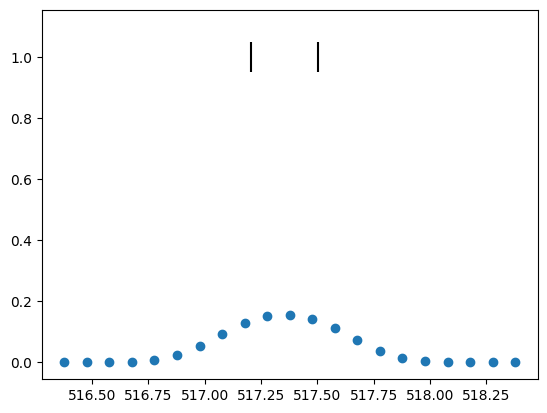

2


In [226]:
neural_activity = []
count = 0
plot_created = False  # Flag to check if plot has been created

for neuron in expt["x"]["clust"]:
    neuron_activity = []
    for start_time, end_time in zip(period_start_times, period_end_times):
        time_grid = np.arange(start_time, end_time, int(1e5))

        # Gather the spike times within the current period
        spike_times = neuron["ts"][
            (neuron["ts"] >= start_time) & (neuron["ts"] <= end_time)
        ]

        if len(spike_times) > 1:
            # Define the kernel
            kernel = gaussian_kde(spike_times)

            if (
                count == 3 and not plot_created
            ):  # This should plot only for the first neuron with more than one spike
                plt.scatter(time_grid * 1e-6, 100000 * kernel.evaluate(time_grid))
                plt.eventplot(
                    spike_times * 1e-6,
                    color="black",
                    linelengths=0.1,
                    label="Original spikes",
                )
                plt.show()  # Show the plot
                plot_created = True  # Update the flag
                print(len(spike_times))

            # Evaluate the density at the relevant times and add it to the density array
            neuron_activity.extend(kernel.evaluate(time_grid))
        else:
            neuron_activity.extend(np.zeros(len(time_grid)))

    neural_activity.append(neuron_activity)
    count += 1  # Increment the counter in the outer loop

    # If plot has been created, break the loop
    if plot_created:
        break

In [10]:
neural_activity = []
count = 0
for neuron in expt["x"]["clust"]:
    neuron_activity = []
    for start_time, end_time in zip(period_start_times, period_end_times):
        time_grid = np.arange(start_time, end_time, int(2e4))

        # Gather the spike times within the current period
        spike_times = neuron["ts"][
            (neuron["ts"] >= start_time) & (neuron["ts"] <= end_time)
        ]

        if len(spike_times) > 1:
            # Define the kernel
            kernel = gaussian_kde(spike_times)

            activity = len(spike_times) * kernel.evaluate(time_grid)

            neuron_activity.extend(activity)
        else:
            neuron_activity.extend(np.zeros(len(time_grid)))
    count += 1
    neural_activity.append(neuron_activity)

neural_activity = np.array(neural_activity).T

In [11]:
# define function to interpolate variable values at specified times
def interpolate_variable(variable_values, recorded_times, new_times):
    # create an interpolation function based on the recorded times and values
    f = interp1d(
        recorded_times, variable_values, bounds_error=False, fill_value="extrapolate"
    )

    # use this function to estimate the variable values at the new times
    return f(new_times)

**Obtain interpolations of lab measurements at corresponding times**

In [12]:
recorded_angles = expt["x"]["rosdata"]["encAngle"]
recorded_times = expt["x"]["rosdata"]["encTimes"]
recorded_vel = expt["x"]["rosdata"]["vel"]
recorded_gain = expt["x"]["rosdata"]["gain"]


angles = []
all_times = []
velocities = []
gains = []

# For each period of high velocity
for start_time, end_time in zip(period_start_times, period_end_times):
    time_grid = np.arange(start_time, end_time, int(2e4))

    interpolated_angles = interpolate_variable(
        recorded_angles, recorded_times, time_grid
    )
    interpolated_velocities = interpolate_variable(
        recorded_vel, recorded_times, time_grid
    )
    interpolated_gains = interpolate_variable(recorded_gain, recorded_times, time_grid)
    angles.extend(interpolated_angles)
    velocities.extend(interpolated_velocities)
    gains.extend(interpolated_gains)

angles = np.array(angles)
velocities = np.array(velocities)
gains = np.array(gains)
laps = angles // 360
angles = angles % 360

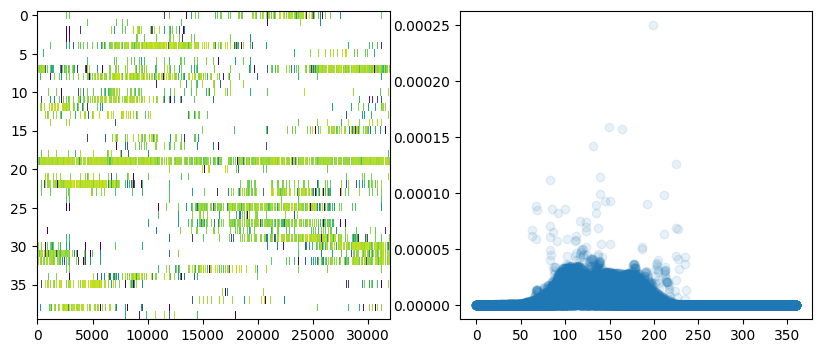

In [14]:
sort = np.argsort(angles)
sorted_angles = angles[sort]
sorted_activity = neural_activity[sort, :]
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.imshow(
    sorted_activity.T, aspect="auto", cmap="viridis", interpolation="none", norm="log"
)
ax2 = fig.add_subplot(122)
ax2.scatter(sorted_angles, sorted_activity[:, 4], alpha=0.1)

**Example of using gaussian kde to smooth spikes**

In [ ]:
# Let's create some synthetic spike data
spike_times = np.array([3, 8, 19, 19.5, 19.6, 19.7, 19.8, 20, 20.2, 31, 32])

# Define the times at which you want to evaluate the density
time_grid = np.linspace(0, spike_times.max() + 10, 10000)  # adjust as needed

# Create the Gaussian KDE
kernel = gaussian_kde(spike_times)

# Evaluate the density at the given times
density = kernel.evaluate(time_grid)

# Plot the original spikes
plt.figure(figsize=(10, 6))
plt.eventplot(spike_times, color="black", linelengths=0.1, label="Original spikes")

# Plot the KDE
plt.plot(time_grid, density, label="Gaussian KDE")
plt.xlabel("Time")
plt.ylabel("Density")
plt.legend()
plt.title("Spike data and Gaussian KDE")
plt.show()

## Load neural activity & labels
Using `neurometry.datasets.experimental.load_neural_activity`

In [253]:
import neurometry.datasets.experimental as experimental

expt_id = "34"
timestep_microsec = int(4e5)
vel_threshold = 5

neural_activity, labels = experimental.load_neural_activity(
    expt_id=expt_id, vel_threshold=vel_threshold, timestep_microsec=timestep_microsec
)

times_in_seconds = labels["times"] * 1e-6
angles = labels["angles"]

print(
    f"There are {neural_activity.shape[1]} neurons binned over {neural_activity.shape[0]} timesteps"
)

INFO: # - Found file at /Users/facosta/Desktop/code/neurometry/neurometry/data/binned/expt34_times_timestep400000_velthreshold_5.txt! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neurometry/neurometry/data/binned/expt34_neural_activity_timestep400000_velthreshold_5.npy! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neurometry/neurometry/data/binned/expt34_labels_timestep400000_velthreshold_5.txt! Loading...


There are 40 neurons binned over 1613 timesteps


Visualize activity over time (PSTH) -- no speed thresholding

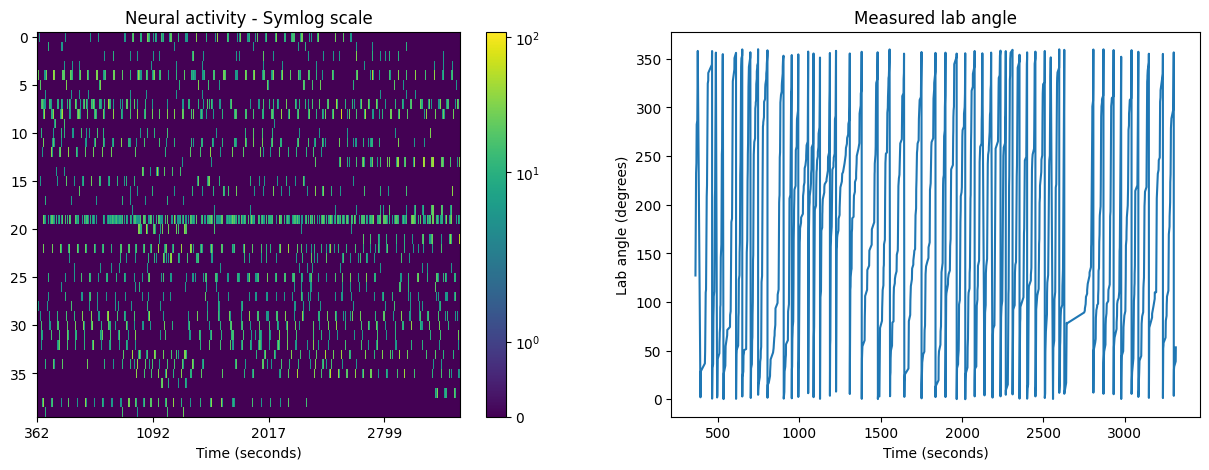

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

psth = axs[0].imshow(
    neural_activity.T,
    aspect="auto",
    cmap="viridis",
    norm="symlog",
    interpolation="none",
)
axs[0].set_title("Neural activity - Symlog scale")
axs[0].set_xticks(np.arange(len(times_in_seconds))[::1000])
axs[0].set_xticklabels(times_in_seconds[::1000].astype(int))
axs[0].set_xlabel("Time (seconds)")

fig.colorbar(psth, ax=axs[0])

axs[1].plot(times_in_seconds, angles)
axs[1].set_xlabel("Time (seconds)")
axs[1].set_ylabel("Lab angle (degrees)")
axs[1].set_title("Measured lab angle");

## Calculate Mutual Information between angular position and activity for each neuron

!!!!!TODO!!!!!: 

Look for existing implementation of multivariate mutual information

For now: account for topology of task by definining mutual information between position $\theta$ and neural activity $r_i$ of neuron $i$ as:

$$ \text{MI}(r_i,\theta) \equiv \text{MI}(r_i,\cos{\theta}) + \text{MI}(r_i,\sin{\theta}) $$


where $$ \text{MI}(X,Y) = \text{KL}(p_{XY}(x,y)||p_X(x)p_Y(y)) = \int \int  \ \textrm{d}x \ \textrm{d}y \ p_{XY}(x,y) \log{\frac{p_{XY}(x,y)}{p_X(x)p_Y(y)}}$$


What are other tests of independence/ correlation coefficiens?

See:
- https://journals.aps.org/pre/pdf/10.1103/PhysRevE.69.066138
- https://arxiv.org/pdf/1307.7383.pdf
- https://arxiv.org/pdf/1909.10140.pdf
- https://github.com/minepy/mictools

In [15]:
from sklearn.feature_selection import mutual_info_regression

angles_radians = angles * np.pi / 180

X = np.cos(angles_radians)
Y = np.sin(angles_radians)

spatial_mutual_info_X = mutual_info_regression(neural_activity, X)
spatial_mutual_info_Y = mutual_info_regression(neural_activity, Y)
spatial_mutual_info_XY = spatial_mutual_info_X + spatial_mutual_info_Y

**Visualize peristimulus angle histogram (PSAH) with individual spatial mutual information score**

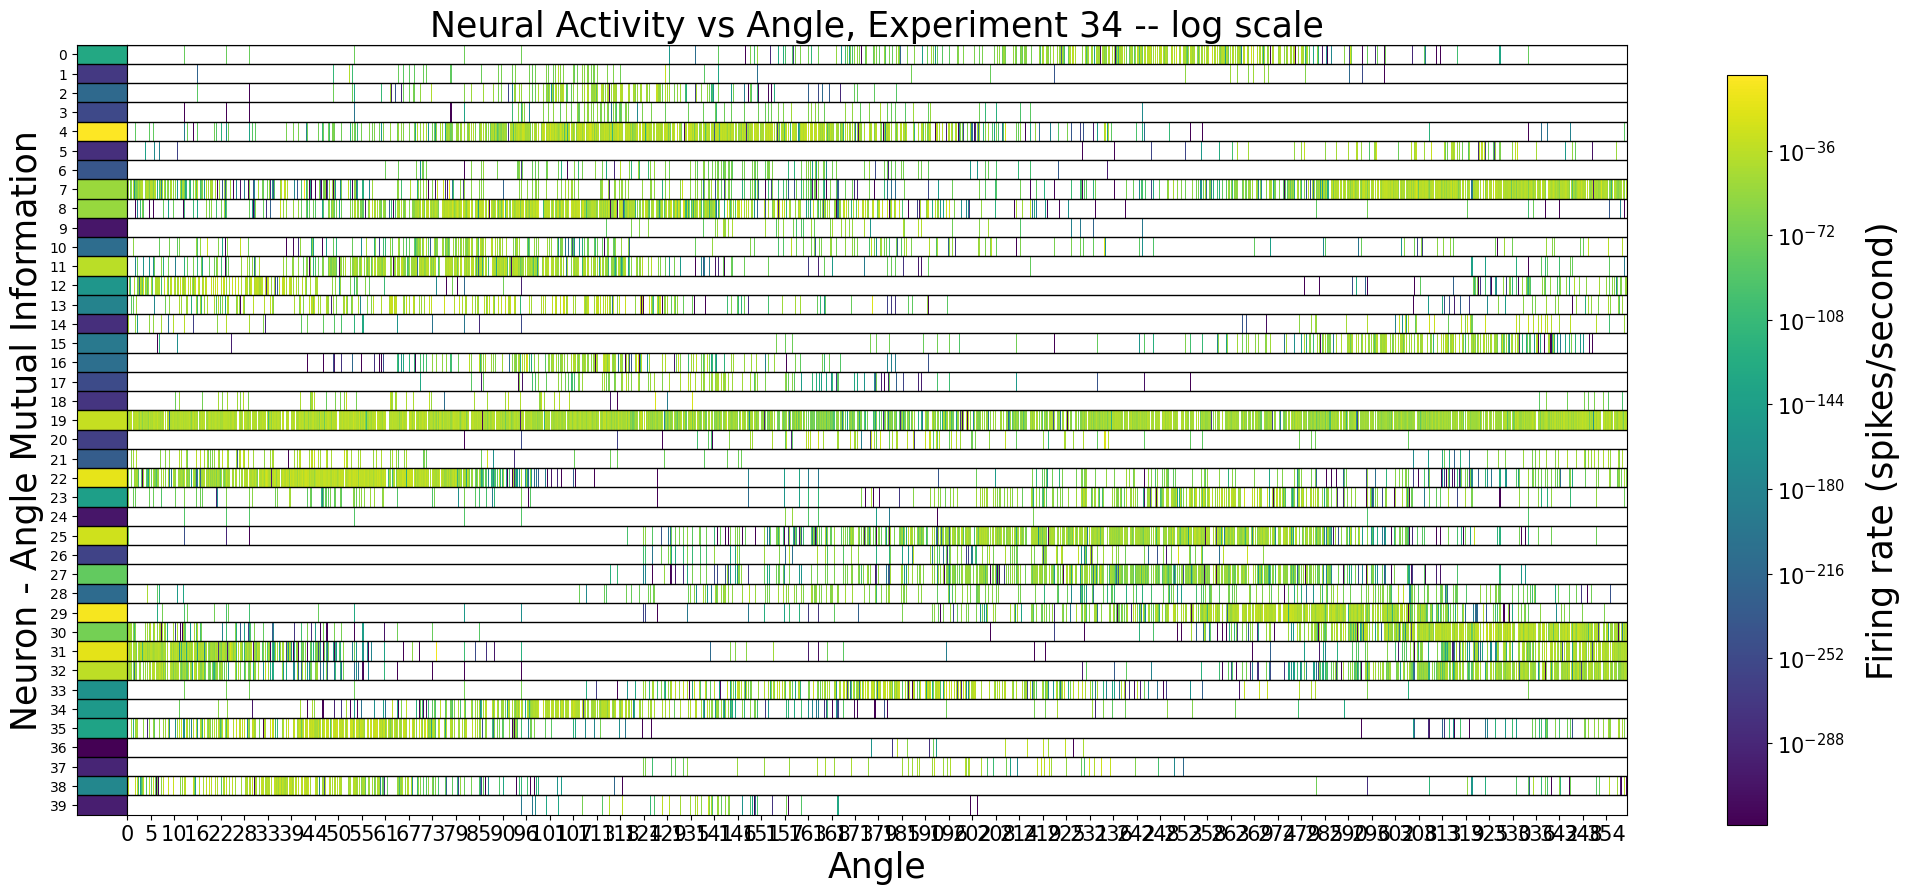

In [16]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_neural_activity = neural_activity[sort, :]

viz.plot_activity_with_mi(
    expt_id=expt_id,
    name="Angle",
    neural_activity=sorted_neural_activity,
    task_variable=sorted_angles,
    mutual_info=spatial_mutual_info_XY,
    norm="log",
)

Set Spatial Mutual Information threshold

there are 26 neurons with spatial information above 0.15


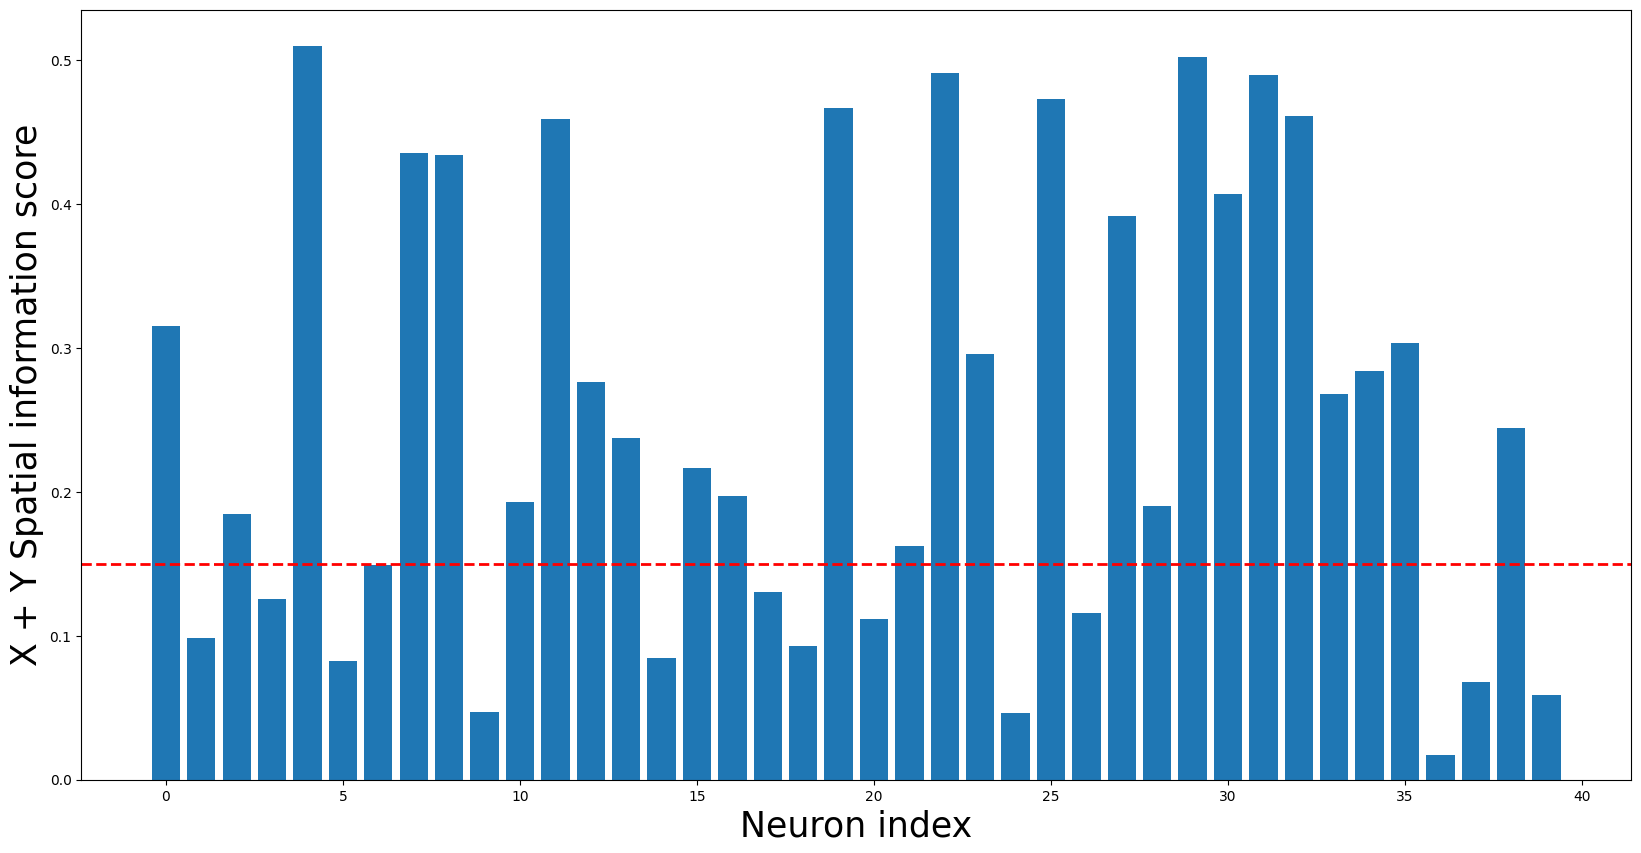

In [17]:
mi_threshold = 0.15

mi_thresh_neural_activity = neural_activity[:, spatial_mutual_info_XY > mi_threshold]

mi_thresh_spatial_mutual_info = spatial_mutual_info_XY[
    spatial_mutual_info_XY > mi_threshold
]

x_ticks = np.arange(0, len(spatial_mutual_info_XY))

fig, axs = plt.subplots(figsize=(20, 10))

axs.bar(x_ticks, spatial_mutual_info_XY)
axs.set_xlabel("Neuron index", fontsize=25)
axs.set_ylabel("X + Y Spatial information score", fontsize=25)
axs.axhline(mi_threshold, color="red", lw=2, linestyle="--", label="MI threshold")

print(
    f"there are {len(mi_thresh_spatial_mutual_info)} neurons with spatial information above {mi_threshold}"
)

## Visualize high MI neurons, organized by place field centers

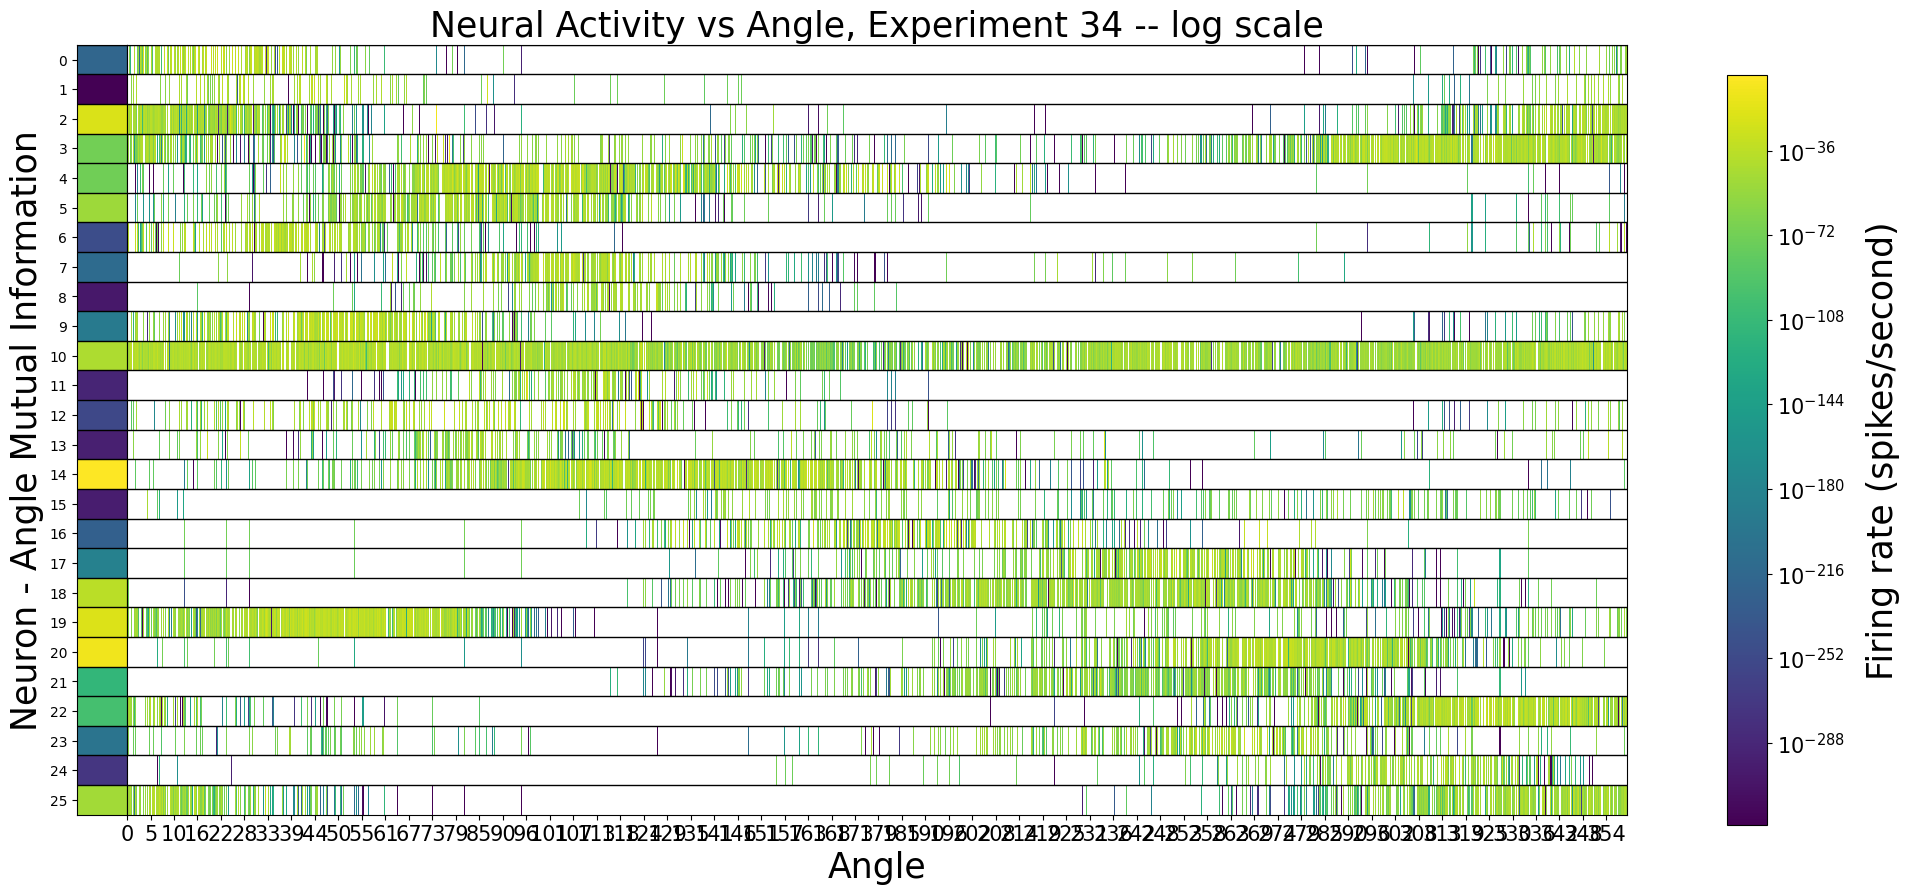

In [18]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]

sorted_mi_thresh_neural_activity = mi_thresh_neural_activity[sort, :]

center_of_mass, center_of_mass_indices = experimental.get_place_field_centers(
    sorted_mi_thresh_neural_activity, sorted_angles
)
com_sort = np.argsort(center_of_mass_indices)

organized_neural_activity = sorted_mi_thresh_neural_activity[:, com_sort]
organized_spatial_mutual_info = mi_thresh_spatial_mutual_info[com_sort]

norm = "log"

viz.plot_activity_with_mi(
    expt_id=expt_id,
    name="Angle",
    neural_activity=organized_neural_activity,
    task_variable=sorted_angles,
    mutual_info=organized_spatial_mutual_info,
    norm=norm,
)

## Visualize 3D projection of neural state space (3 neurons with adjacent place fields)

**Choose neurons to project OR choose random projection**

In [328]:
neuron_x_id, neuron_y_id, neuron_z_id = 4, 7, 25
# neuron_x_id, neuron_y_id, neuron_z_id = 8, 17, 19

# neuron_x_id, neuron_y_id, neuron_z_id = 5, 6, 7 # timestep 2e4


organized_neural_activity = neural_activity

# neuron_x_id, neuron_y_id, neuron_z_id = np.random.choice(organized_neural_activity.shape[1],3,replace=False)

In [329]:
x = organized_neural_activity[:, neuron_x_id]
y = organized_neural_activity[:, neuron_y_id]
z = organized_neural_activity[:, neuron_z_id]

r = np.sqrt(x**2 + y**2 + z**2)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=dict(
                size=3,
                color=sorted_angles,  # set color to an array/list of desired values
                colorscale="hsv",  # choose a colorscale
                opacity=0.5,
            ),
        )
    ]
)

fig.update_layout(autosize=False, width=600, height=600)

fig.show()

In [21]:
import persistent_homology
import viz

In [19]:
organized_neural_activity.shape

(31939, 26)

In [22]:
diagrams = persistent_homology.compute_persistence_diagrams(
    organized_neural_activity, maxdim=1, n_threads=-1
)

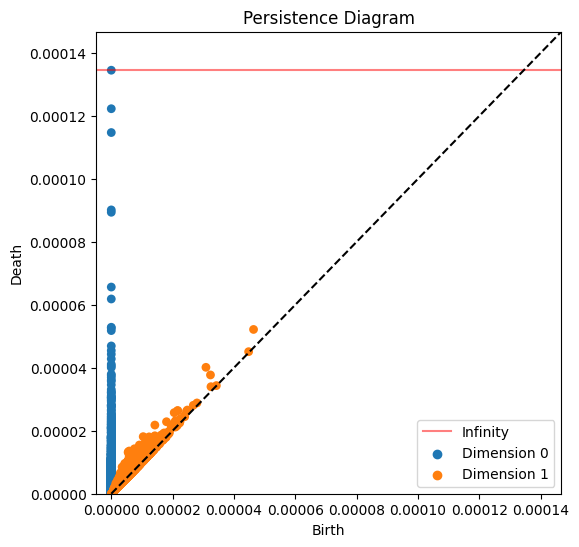

In [292]:
viz.plot_persistence_diagrams(diagrams, density=False)

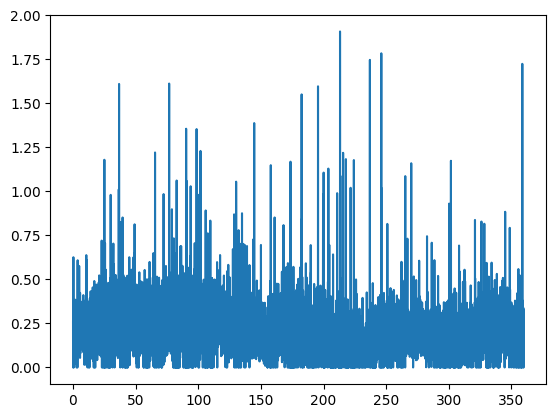

In [289]:
radius = np.linalg.norm(organized_neural_activity, axis=1)
plt.plot(sorted_angles, 1e4 * radius)